In [1]:
from sklearn_som.som import SOM
import pandas as pd
from IPython.core.display import display
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn_som.som import SOM
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
plt.style.use('dark_background')

Can a SOM of the numerical features be combined with a one-hot encoded
version of the non-numerical features to create a multilayer perceptron
classifier that performs well on this data?

-Confirmed

In [2]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/cdavidshaffer/CPSC4970-AI/master/data/penguins.csv')
#removing rows with missing values
raw_data = raw_data.replace("?", np.nan)
raw_data.dropna(how="any", inplace=True)
raw_data = raw_data.fillna("", inplace=False)
raw_data.isnull().sum()

display(raw_data.describe())
display(raw_data.info())
display(raw_data.shape)
display(raw_data.columns)

#first, converting object type columns to float types to work with data
raw_data["culmen_length_mm"] = pd.to_numeric(raw_data.culmen_length_mm, errors='coerce', downcast='float')
raw_data["culmen_depth_mm"] = pd.to_numeric(raw_data.culmen_depth_mm, errors='coerce', downcast='float')
raw_data["flipper_length_mm"] = pd.to_numeric(raw_data.flipper_length_mm, errors='coerce', downcast='float')
raw_data["body_mass_g"] = pd.to_numeric(raw_data.body_mass_g, errors='coerce', downcast='float')

features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

X = raw_data.loc[:,features].values
Y = raw_data.loc[:,['species']]

X_train, X_test, y_train, y_test = train_test_split(raw_data.iloc[:, 2:-1], raw_data['species'])

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,334,334,334,334,334,334,334
unique,3,3,163,79,54,93,3
top,Adelie,Biscoe,41.1,17.0,190.0,3800.0,MALE
freq,146,164,7,12,21,12,168


<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   species            334 non-null    object
 1   island             334 non-null    object
 2   culmen_length_mm   334 non-null    object
 3   culmen_depth_mm    334 non-null    object
 4   flipper_length_mm  334 non-null    object
 5   body_mass_g        334 non-null    object
 6   sex                334 non-null    object
dtypes: object(7)
memory usage: 20.9+ KB


None

(334, 7)

Index(['species', 'island', 'culmen_length_mm', 'culmen_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')

In [3]:
som = SOM(m=3, n=4, dim=X.shape[1])
som.fit(X_train.values)
print(som.predict(X_train.values))

[ 6  3 11  8  4  0  9  0  8  3  5  2  7  1  6  2  2 11  7  8  2  8  8  8
  6 10  7  9  2  8  7  2  8  8  5  7  4  8  5  7 10  3  0  8  0  8  3  8
  3  3  5  6  7  3  3  0  7  7  3  6  2  8  8  2  5  7  9  8 11  8  8 11
  7  8  3  1  3  9  9  9  1  1  9  2 11  8 11  9  9  3  2  8  3 11 11 11
  5  3  8  8  7  2 11  5 11  3  3  4  3  2  6  3 10  9  1  6  3  2  3  6
  3 11  3  0  4  6  3 11  7  8  3  9  9  7  3  6  2  9  2  9  5  2  0  3
  7 11  9  3  7  8  0  7  8  3  6  8 10  9  8  8 10  6  6  9  5  8  9  4
  4  0  8  9  2 10 10  6  6  6  2  6  2  3  8  9  6  8 10  3  1  7  1 11
  2  6  6 11  3 11  5  3  9  9  8  7  4  5  6  6 10  7  9  1  8  7  5  8
  1  8  8  2  3  3  0  7  6 10 10  8  9  9  4  7  5 11  2  2  3  4  3  9
  7  3  3  8  3  0 11  4  9  9]


(250, 4)
(250, 5)
(84, 4)
(84, 5)
Training accuracy: 0.996
Testing accuracy: 0.9880952380952381
{'classifier__alpha': 0.2, 'classifier__hidden_layer_sizes': (20,)}


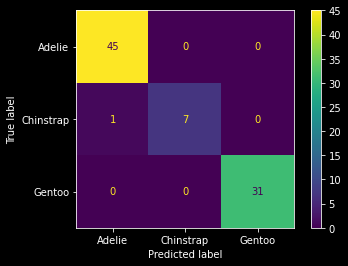

In [4]:
aug_X_train = np.append(X_train, som.predict(X_train.values).reshape(-1, 1), axis=1)
print(X_train.shape)
print(aug_X_train.shape)
aug_X_test = np.append(X_test, som.predict(X_test.values).reshape(-1, 1), axis=1)
print(X_test.shape)
print(aug_X_test.shape)

pipeline = Pipeline(
    [('preproc', make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), [aug_X_train.shape[1]-1]),
        (StandardScaler(), slice(0, aug_X_train.shape[1]-1)))),
     ('classifier', MLPClassifier(max_iter=2000))]
)

cv_params = {
    'classifier__hidden_layer_sizes': [(10, ), (20, ), (40, ), (80, ),
                                       (10, 5), (20, 10), (40, 20), (80, 40)],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4]
}

cv = GridSearchCV(pipeline, cv_params, n_jobs=-1)
cv.fit(aug_X_train, y_train)
print("Training accuracy:", accuracy_score(y_train, cv.predict(aug_X_train)))
print("Testing accuracy:", accuracy_score(y_test, cv.predict(aug_X_test)))
from sklearn.metrics import plot_confusion_matrix
print(cv.best_params_)
plot_confusion_matrix(cv, aug_X_test, y_test)

